### Generate training and testing sets

In [63]:
import pandas as pd
import numpy as np
import sklearn.linear_model as linear
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import root_mean_squared_error as rmse
from math import e

In [64]:
# essentially ripped straight from the book
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(rmse(y_train[:m], y_train_predict))
        val_errors.append(rmse(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              
    plt.show()

In [65]:
np.random.seed(999)
x = 20 * np.random.rand(500, 1) - 10 # [-10, 10)
y_clean = 1 / (1+e**(-x))
y_noise = 1 / (1+e**(-x)) + np.random.normal(0, .38) # 0.5X + x^2 + 2 + Gaussian noise

In [66]:
np.random.normal(0, .38, 9999999).var() # sd of .38 -> variance of .15

0.14433096322719216

In [67]:
x_train = x[:400]
x_test = x[400:]

y_clean_train = y_clean[:400]
y_clean_test = y_clean[400:]

y_noise_train = y_noise[:400]
y_noise_test = y_noise[400:]


In [68]:
y_clean_test.shape

(100, 1)

In [69]:
y_clean_train.shape

(400, 1)

## Initial models

In [70]:
# fit the model with the given data, print the coefficient and intercept, find the RMSE on the train and validation data, and plot
def train_eval(model, x = x, y_clean = y_clean, y_noise = y_noise):
    # break up the data into training and validation/testing
    x_train = x[:400]
    x_test = x[400:]

    y_clean_train = y_clean[:400]
    y_clean_test = y_clean[400:]

    y_noise_train = y_noise[:400]
    y_noise_test = y_noise[400:]

    # fit the clean model
    clean = model.fit(x_train, y_clean_train)
    print(f'Clean model intercept: {clean.intercept_[0]}')
    print(f'Clean model coefficient: {clean.coef_[0]}')

    # get predictions for the training and testing/validation data
    clean_train_predictions = clean.predict(x_train)
    clean_test_predictions = clean.predict(x_test)

    print(f'Clean model training RMSE: {rmse(clean_train_predictions, y_clean_train)}')
    print(f'Clean model testing RMSE: {rmse(clean_test_predictions, y_clean_test)}')

    # fit the noisy model
    noisy = model.fit(x_train, y_noise_train)
    print(f'Noisy model intercept: {noisy.intercept_[0]}')
    print(f'Noisy model coefficient: {noisy.coef_[0]}')

    # get predictions for the training and testing/validation data
    noisy_train_predictions = noisy.predict(x_train)
    noisy_test_predictions = noisy.predict(x_test)

    print(f'Noisy model training RMSE: {rmse(noisy_train_predictions, y_noise_train)}')
    print(f'Noisy model testing RMSE: {rmse(noisy_test_predictions, y_noise_test)}')

    print("Clean model")
    plot_learning_curves(clean, x_train, y_clean_train)

    print("Noisy model")
    plot_learning_curves(noisy, x_train, y_clean_train)

Clean model intercept: 0.49541174039549657
Clean model coefficient: [0.07168985]
Clean model training RMSE: 0.1571030031186975
Clean model testing RMSE: 0.16793948494279742
Noisy model intercept: 1.297525423103019
Noisy model coefficient: [0.07168985]
Noisy model training RMSE: 0.1571030031186975
Noisy model testing RMSE: 0.16793948494279742
Clean model


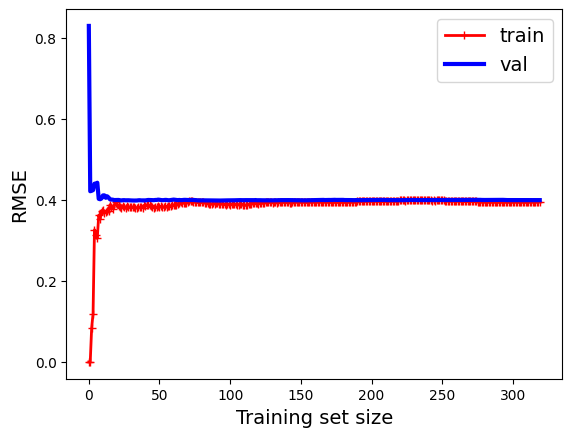

Noisy model


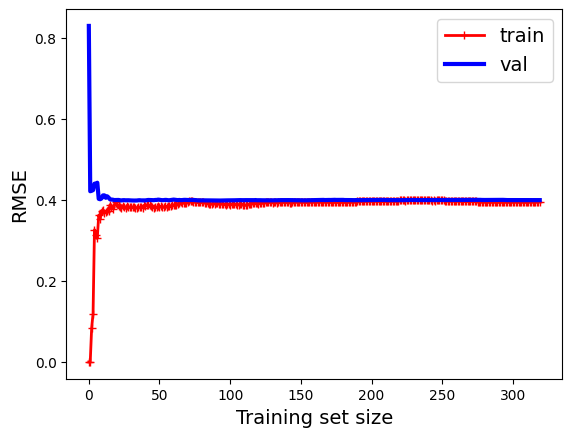

In [73]:
ols = linear.LinearRegression()
train_eval(ols)

Pretty significant bias due to polynomial component, but similar results between the clean and noisy models.

looks like either the graphs or my numbers are off, .4 vs .16

Polynomial regression, order 2

Number of polynomial features: 2
Clean model intercept: 0.4966940406630843
Clean model coefficient: [ 7.16969087e-02 -3.69138984e-05]
Clean model training RMSE: 0.15709901977625576
Clean model testing RMSE: 0.16793715391129818
Noisy model intercept: 1.298807723370607
Noisy model coefficient: [ 7.16969087e-02 -3.69138984e-05]
Noisy model training RMSE: 0.1570990197762558
Noisy model testing RMSE: 0.16793715391129815
Clean model


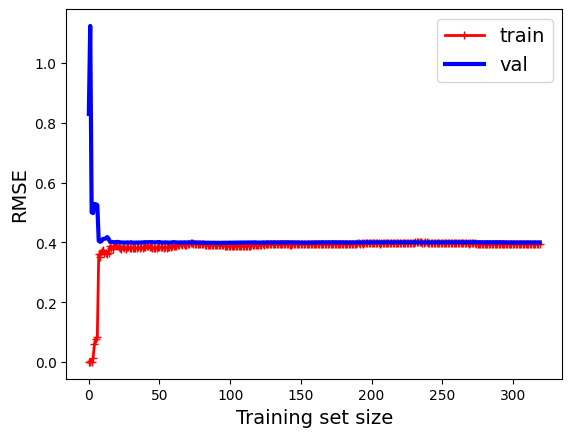

Noisy model


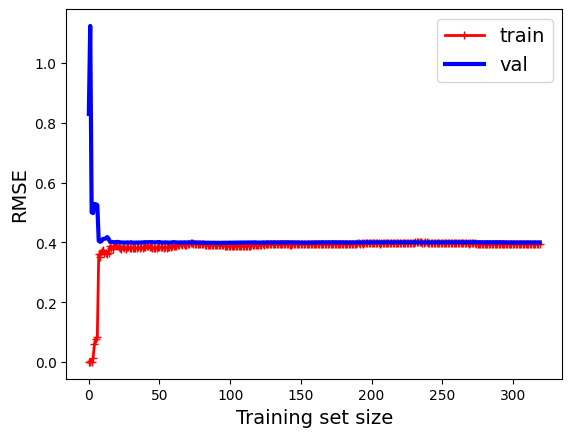

Number of polynomial features: 3
Clean model intercept: 0.4956756786732067
Clean model coefficient: [ 1.26761339e-01  1.03387576e-04 -9.00063736e-04]
Clean model training RMSE: 0.07438033094052164
Clean model testing RMSE: 0.08341891839162441
Noisy model intercept: 1.2977893613807294
Noisy model coefficient: [ 1.26761339e-01  1.03387576e-04 -9.00063736e-04]
Noisy model training RMSE: 0.07438033094052164
Noisy model testing RMSE: 0.0834189183916244
Clean model


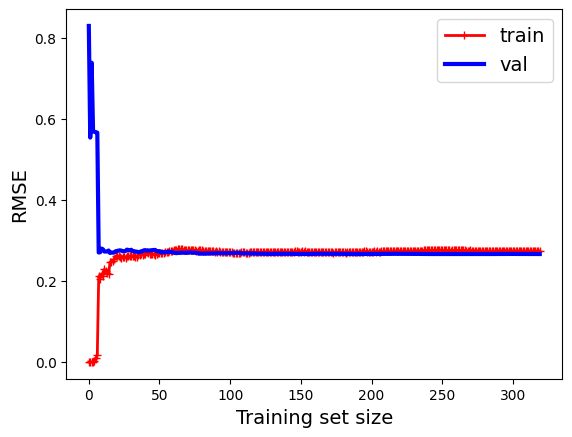

Noisy model


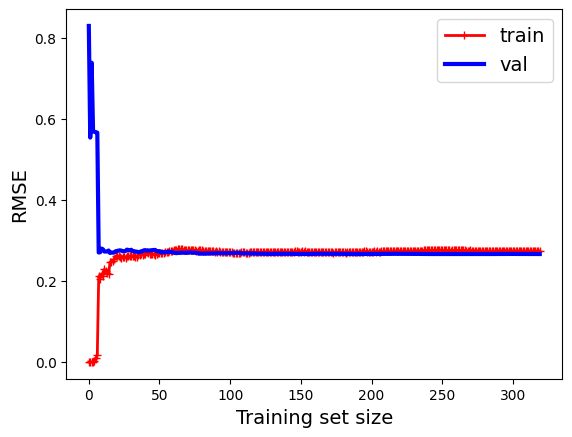

Number of polynomial features: 4
Clean model intercept: 0.4993021282574015
Clean model coefficient: [ 1.26826823e-01 -2.49168876e-04 -9.01365330e-04  4.05769967e-06]
Clean model training RMSE: 0.07431878403279338
Clean model testing RMSE: 0.08355786194181687
Noisy model intercept: 1.301415810964924
Noisy model coefficient: [ 1.26826823e-01 -2.49168876e-04 -9.01365330e-04  4.05769967e-06]
Noisy model training RMSE: 0.07431878403279338
Noisy model testing RMSE: 0.08355786194181689
Clean model


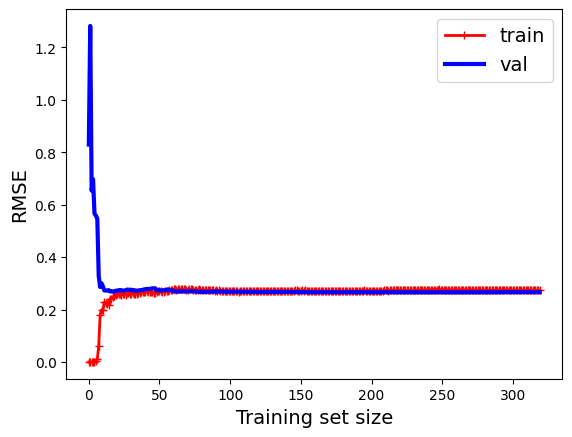

Noisy model


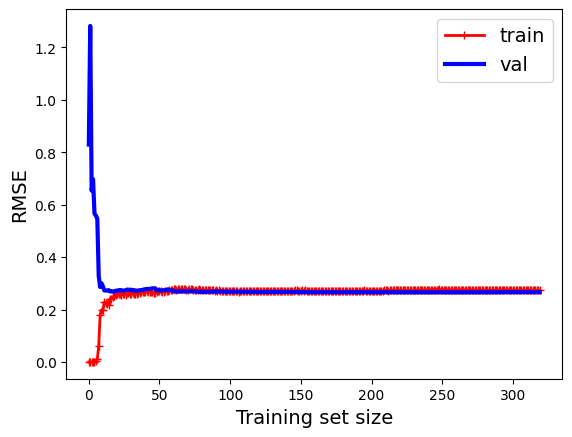

Number of polynomial features: 5
Clean model intercept: 0.5016234175578939
Clean model coefficient: [ 1.66099217e-01 -1.85317943e-04 -2.75888070e-03  1.76163381e-06
  1.68158646e-05]
Clean model training RMSE: 0.03866072542812946
Clean model testing RMSE: 0.044288607790836994
Noisy model intercept: 1.3037371002654163
Noisy model coefficient: [ 1.66099217e-01 -1.85317943e-04 -2.75888070e-03  1.76163381e-06
  1.68158646e-05]
Noisy model training RMSE: 0.038660725428129476
Noisy model testing RMSE: 0.044288607790837
Clean model


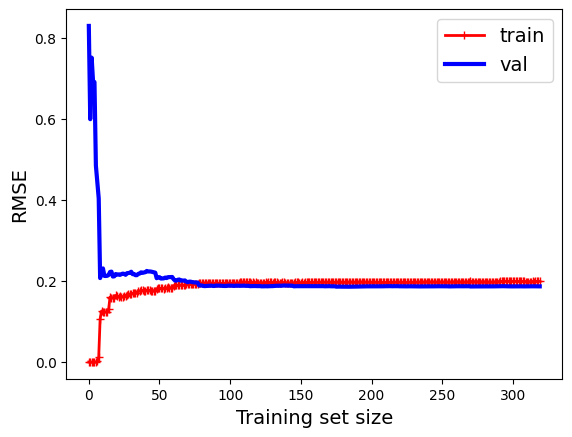

Noisy model


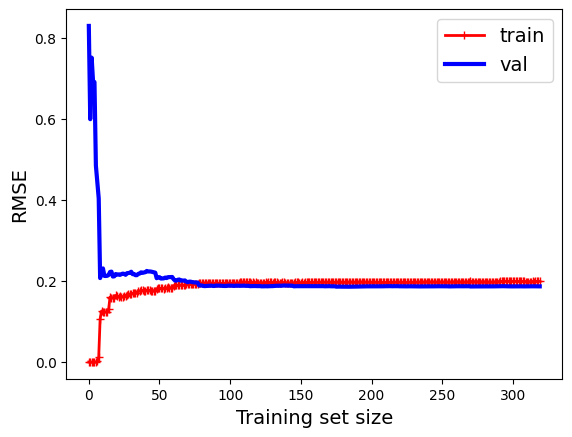

In [72]:
for i in range(2, 6):
    print(f'Number of polynomial features: {i}')
    poly_features = PolynomialFeatures(degree = i, include_bias = False)
    x_poly = poly_features.fit_transform(x)
    train_eval(linear.LinearRegression(), x_poly)
